In [1]:
from pandas import read_csv
import pandas as pd
from pytz import timezone
import pytz
from datetime import datetime
import re

# Load data
# DATAFILE MUST BE IN THE SAME FOLDER AS THIS NOTEBOOK
# If not, you need to edit the path
path = r"protonml-signups_for_ML.csv"
data = read_csv(path)
data_og = data.copy()
print(data.shape)

print(data.dtypes)

# Mostly string data; need to convert to more convenient data types
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Try to convert to local time from given timezone
# If no timezone available, infer roughly from continent
def to_local_time(t, tz, continent):
    f = t.tz_localize('UTC')
    try:
        return f.tz_convert(tz)
    except:
        if (continent=='Europe'):
            return f.tz_convert('CET')
        elif (continent=='Asia'):
            return f.tz_convert('Asia/Shanghai')
        elif (continent=='North-America'):
            return f.tz_convert('America/Chicago')
        elif (continent=='South-America'):
            return f.tz_convert('America/Sao_Paulo')
        elif (continent=='Africa'):
            return f.tz_convert('Africa/Lagos')
        elif (continent=='Oceania'):
            return f.tz_convert('Australia/Sydney')
        else:
            return t

# After datetime is localized, remove trailing timezone info to make the parsing easier
def clean_timestamp(t):
    st = str(t)
    if re.search('-\d\d:\d\d', st):
        st = st[:-6]
    if re.search('\+\d\d:\d\d', st):
        st = st[:-6]
    return st

# Only 'js_timezone' has missing values, so that may be an information in itself
# Add a column in the data that indicates if the timezone is missing
def flag_missing_tz(tz):
    #print(tz)
    return (len(tz)==0)

# Numeric or categorical attributes are more convenient for stats/modeling
# Using the hour of the day should give enough info for now
def get_hour(t):
    time = datetime.strptime(t, '%Y-%m-%d %H:%M:%S')
    return time.hour

# There may be cyclical variations depending on the day of the week
def get_weekday(t):
    time = datetime.strptime(t, '%Y-%m-%d %H:%M:%S')
    return time.weekday()

# Localize datetime, then get hour and weekday ; flag missing timezone
data['timestamp'] = data.apply(lambda row : to_local_time(row['timestamp'], row['js_timezone'], row['ip_continent']), axis=1)
data['timestamp'] = data.apply(lambda row : clean_timestamp(row['timestamp']), axis=1)
data['hour'] = data.apply(lambda row : get_hour(str(row['timestamp'])), axis=1)
data['weekday'] = data.apply(lambda row : get_weekday(str(row['timestamp'])), axis=1)
data['missing_tz'] = data.apply(lambda row : flag_missing_tz(str(row['js_timezone'])), axis=1)

print(data.dtypes)
#print(data)

print("\nDone")

(100000, 6)
timestamp             object
ip_country            object
ip_continent          object
js_timezone           object
http_lang             object
http_platform_name    object
dtype: object
timestamp             object
ip_country            object
ip_continent          object
js_timezone           object
http_lang             object
http_platform_name    object
hour                   int64
weekday                int64
missing_tz              bool
dtype: object

Done



Done


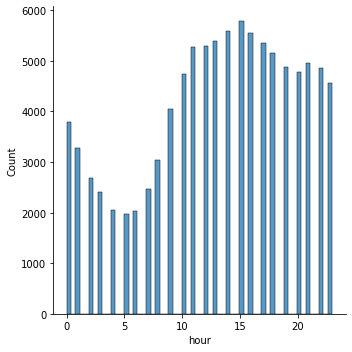

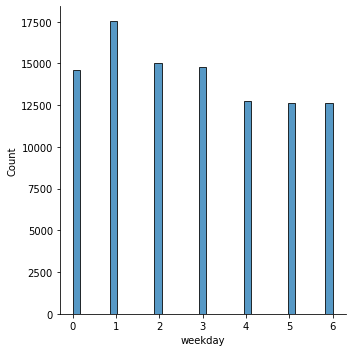

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(data['hour'])
sns.displot(data['weekday'])

print("\nDone")

# Signups are much less common between 2am and 7am, 
# which seems normal and suggests the time localization worked correctly

# No strong weekly cyclical behavior; more frequent between Sunday and Wednesday, with a spike on Mondays

In [3]:
# We handled the timestamp, but there are other string columns

print(len(data['ip_country'].unique()), 'countries')
print(len(data['ip_continent'].unique()), 'continents')
print(len(data['js_timezone'].unique()), 'timezones')
print(len(data['http_lang'].unique()), 'http langs')
print(len(data['http_platform_name'].unique()), 'platforms')

print("\nDone")

# The counts for countries, continents, and platforms look normal
# Timezones and languagues are more suspicious, and probably have some duplicates in there

202 countries
7 continents
352 timezones
705 http langs
9 platforms

Done


In [4]:
print(data['js_timezone'].unique())
print(data['http_lang'].unique())

print("\nDone")

['CET' 'Europe/Moscow' 'America/Los_Angeles' 'Asia/Taipei'
 'Europe/Tallinn' 'Africa/Lagos' nan 'Asia/Tokyo' 'UTC' 'America/New_York'
 'America/Chicago' 'America/Toronto' 'Europe/London' 'Europe/Amsterdam'
 'Europe/Warsaw' 'Asia/Shanghai' 'Europe/Rome' 'America/Sao_Paulo'
 'Europe/Bucharest' 'Europe/Belgrade' 'Europe/Istanbul' 'Asia/Kolkata'
 'Europe/Copenhagen' 'Pacific/Auckland' 'Asia/Dhaka' 'Europe/Dublin'
 'Asia/Calcutta' 'Australia/Sydney' 'Africa/Cairo' 'Africa/Abidjan'
 'Europe/Stockholm' 'America/Hermosillo' 'America/Santiago'
 'Europe/Madrid' 'Africa/Nairobi' 'Asia/Singapore' 'Asia/Karachi'
 'Europe/Sofia' 'Asia/Kuala_Lumpur' 'America/Denver' 'Europe/Helsinki'
 'America/Caracas' 'America/Halifax' 'Asia/Jerusalem' 'Europe/Paris'
 'Asia/Jakarta' 'Asia/Tehran' 'Europe/Berlin' 'Europe/Budapest'
 'Europe/Zurich' 'America/Mexico_City' 'Europe/Vienna' 'Asia/Dubai'
 'Pacific/Apia' 'Asia/Hong_Kong' 'Asia/Baghdad' 'Asia/Manila'
 'Europe/Athens' 'America/Guadeloupe' 'Europe/Lisbon' 'Asia

In [5]:
# The timezones look correct, and seem to carry useful information about the geographical origin

# The languages are slightly confusing
# Data cleaning could probably help here, but I don't have the knowledge about language codes
# The language itself seems to be contained in the first two characters, so we will just go with that for now

def trunc_lang(t):
    st = str(t)
    return st[:2]

truncated_langs = data.apply(lambda row : trunc_lang(row['http_lang']), axis=1)

print(truncated_langs.unique())
print(len(truncated_langs.unique()), 'truncated langs')

print("\nDone")

# That's better

['fr' 'hy' 'en' 'zh' 'ar' 'ja' 'bg' 'nl' 'pt' 'ro' 'tr' 'da' 'es' 'de'
 'be' 'ru' 'sv' 'pl' 'az' 'ko' 'it' 'uz' 'uk' 'hi' 'lt' 'tl' 'fi' 'cs'
 'vi' 'id' 'na' 'nb' 'he' 'hr' 'el' 'iw' 'in' 'hu' 'lv' 'fa' 'sl' 'sk'
 'mk' 'th' 'ca' 'ia' 'bs' 'et' 'sr' 'ac' 'am' 'yu' 'no' 'ms' 'nn' 'bn'
 'mr' 'lb' 'mn' 'eu' 'cy' 'us' 'ck' 'sc' 'gl' 'ga' 'my' 'pa' 'un' 'ur'
 'jv' 'br' 'ak']
73 truncated langs

Done


In [6]:
# One-hot encoding for categorical attributes seems to be the most reasonable choice here
# After transformation, we have about 700 attributes in total

from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Encode the 'easy' attributes
data = pd.get_dummies(data, columns=['ip_continent','http_platform_name'], prefix = ['continent','http_platform'])

# Truncate language codes
data['http_lang'] = data.apply(lambda row : trunc_lang(row['http_lang']), axis=1)

# Encode the other attributes
data = pd.get_dummies(data, columns=['http_lang'], prefix = ['lang'])
data = pd.get_dummies(data, columns=['ip_country'], prefix = ['country'])

# Adding the one-hot attributes for 'js_timezone' made the model not fit into memory
# So we will dispense from it for now and get back to it later (hopefully)
#data = pd.get_dummies(data, columns=['js_timezone'], prefix = ['js_timezone'])

print(data.shape)

print("\nDone")

(100000, 293)

Done


In [7]:
#pd.set_option('display.max_rows', None)
print(data.dtypes)
#pd.set_option('display.max_rows', 10)

print("\nDone")

# We still have two unusable columns 'timestamp' and 'js_timezone'
# Keeping them in the dataframe for now, will be removed from the data array for modeling

timestamp            object
js_timezone          object
hour                  int64
weekday               int64
missing_tz             bool
                      ...  
country_Venezuela     uint8
country_Vietnam       uint8
country_Yemen         uint8
country_Zambia        uint8
country_Zimbabwe      uint8
Length: 293, dtype: object

Done


In [8]:
# Now we can start looking for outliers
# Using IsolationForests (see attached report for more details on model choice etc.)

#from sklearn.cluster import DBSCAN,OPTICS
from sklearn.ensemble import IsolationForest
#from sklearn.neighbors import NearestNeighbors
from collections import Counter
from itertools import chain
import numpy as np
import random
import gc

gc.collect()

# Removing 'timestamp' and 'js_timezone'
X = np.array(data)
X = np.delete(X, np.s_[0,1], axis=1)
#X = np.delete(X, np.s_[:95000], axis=0)
print(X.shape)

# Using a 'n_estimators' that gives a decent amount of outliers for a first approach
# Note that since we do not have any ground truth, we just 'fit_predict' over the whole dataset and see how it goes
# Basically, the model assigns outliers to the cluster '-1'
# So we can map the indices back to the original data that we conveniently saved at the start
clf = IsolationForest(n_estimators=5, random_state=12)
preds = clf.fit_predict(X)
outliers = []
#print(preds[:200])
for x in range(len(preds)):
    if preds[x]==-1:
        outliers.append(x)
print('There are', len(outliers), 'outliers')
num_to_print = min(len(outliers),100)
print(outliers[:num_to_print])
for x in range(num_to_print):
    print(data_og.iloc[[outliers[x]]])

print("\nDone")

# Results vary greatly depending on 'random_state' (which is normal)
# With this state, I get 1019 outliers
# Looking at the first few dozens, most of them look suspicious indeed
# As a non-expert, 'suspicious' to me means that the attributes for one entry do not match intuitively
# e.g. here the first one is from an IP in Indonesia, in the Moscow timezone, with Belarusian language
# then the third one is from an IP in Qatar in the New York timezone
# etc.
# Some look normal, e.g. the second one looks like a regular signup from Berlin
# But overall many of them are suspicious, so the model should be OK for a first approximation

(100000, 291)
There are 1019 outliers
[67, 147, 199, 302, 339, 342, 357, 380, 970, 1031, 1042, 1080, 1186, 1271, 1374, 1397, 1416, 1484, 1530, 1847, 1866, 2103, 2347, 2375, 2486, 2508, 2569, 2605, 2902, 3324, 3364, 3403, 3426, 3521, 3657, 3988, 4052, 4114, 4167, 4189, 4297, 4413, 4428, 4441, 4447, 4535, 4701, 5054, 5177, 5213, 5445, 5481, 5685, 5756, 5857, 5892, 6058, 6076, 6151, 6383, 6543, 6552, 6629, 6815, 6917, 7081, 7087, 7102, 7165, 7378, 7459, 7701, 7721, 7769, 7929, 7943, 8079, 8283, 8621, 8892, 8943, 9018, 9252, 9413, 9506, 9564, 9911, 10144, 10165, 10215, 10283, 10319, 10439, 10529, 10672, 10702, 10705, 10731, 10861, 10890]
              timestamp ip_country ip_continent    js_timezone http_lang  \
67  2020-08-06 15:17:53  Indonesia         Asia  Europe/Moscow     be-by   

   http_platform_name  
67            Windows  
               timestamp ip_country ip_continent    js_timezone http_lang  \
147  2020-08-02 15:05:29    Germany       Europe  Europe/Berlin     de-DE   

  

9564            Windows  
                timestamp ip_country ip_continent    js_timezone http_lang  \
9911  2020-08-15 11:22:29      India         Asia  Europe/Moscow     be-by   

     http_platform_name  
9911            Windows  
                 timestamp     ip_country   ip_continent       js_timezone  \
10144  2020-07-31 07:34:17  United-States  North-America  America/New_York   

      http_lang http_platform_name  
10144     it-it                iOS  
                 timestamp ip_country ip_continent    js_timezone http_lang  \
10165  2020-08-08 16:12:55  Indonesia         Asia  Europe/Moscow     be-by   

      http_platform_name  
10165            Windows  
                 timestamp ip_country ip_continent    js_timezone http_lang  \
10215  2020-07-30 10:14:09    Vietnam         Asia  Europe/Moscow     be-by   

      http_platform_name  
10215            Windows  
                 timestamp ip_country ip_continent    js_timezone http_lang  \
10283  2020-08-19 04:15:04   

In [9]:
# Since results vary greatly, and each run of the model cannot cover the whole dataset (lest we blow up the memory)
# An option is to run the model several times independently
# and to report the entries that are detected as outliers by several instances of the model

# Returns a Counter with the frequencies of outliers
# Parameter is a list of lists of outliers (= list of results for each instance of the model)
def frequency(*lists):
    counter = Counter()
    for lis in chain(*lists):
        counter.update(lis)
    return counter
    #return counter.most_common(num_top)

# Get entries from the Counter cnt that occur at least k times
def occurs_at_least_k_times(cnt, k):
    index_list = []
    tmp = cnt.most_common()
    for x in range(len(tmp)):
        if(tmp[x][1]>=k):
            index_list.append(tmp[x][0])
    return index_list

# Number of independent runs of the model
num_iter = 20
# Root seed for reproducibility
seed = 12
random.seed(seed)

# Run the model several times and store the results (outliers list)
# Each iteration takes a few seconds on my computer, so it should finish in a few minutes
outliers_lists = []
for _ in range(num_iter):
    # Generate a "random" seed for this instance of the model
    rand_state = random.randrange(1000)
    print('Random state = ', rand_state)
    clf = IsolationForest(n_estimators=5, max_samples=100, random_state=rand_state)
    preds = clf.fit_predict(X)
    outliers = []
    for x in range(len(preds)):
        if preds[x]==-1:
            outliers.append(x)
    print('There are', len(outliers), 'outliers\n')
    outliers_lists.append(outliers)


print("\nDone")

Random state =  485
There are 1497 outliers

Random state =  275
There are 2296 outliers

Random state =  673
There are 853 outliers

Random state =  541
There are 505 outliers

Random state =  682
There are 1603 outliers

Random state =  358
There are 538 outliers

Random state =  146
There are 137 outliers

Random state =  390
There are 883 outliers

Random state =  11
There are 1732 outliers

Random state =  383
There are 1289 outliers

Random state =  494
There are 4408 outliers

Random state =  280
There are 165 outliers

Random state =  658
There are 213 outliers

Random state =  829
There are 1104 outliers

Random state =  471
There are 356 outliers

Random state =  707
There are 1025 outliers

Random state =  885
There are 2325 outliers

Random state =  615
There are 146 outliers

Random state =  233
There are 2036 outliers

Random state =  571
There are 138 outliers


Done


In [10]:
k = 4
cnt = frequency(outliers_lists)
sus = occurs_at_least_k_times(cnt, k)
print(len(sus), 'entries appear at least', k, 'times as outliers')
for x in sus:
    print(data_og.iloc[[x]])

print("\nDone")

# 110 entries appear at least 4 times as outliers
# Mixed bag; some look suspicious, some look legit, some are in-between 

110 entries appear at least 4 times as outliers
                 timestamp   ip_country ip_continent    js_timezone http_lang  \
11094  2020-08-12 23:43:13  Philippines         Asia  Europe/Moscow     de-de   

      http_platform_name  
11094             Mac OS  
                 timestamp   ip_country ip_continent    js_timezone http_lang  \
37306  2020-07-28 10:27:05  Philippines         Asia  Europe/Moscow     de-de   

      http_platform_name  
37306             Mac OS  
                 timestamp ip_country   ip_continent      js_timezone  \
20760  2020-08-16 15:39:53  Venezuela  South-America  America/Caracas   

      http_lang http_platform_name  
20760     es-CL              Linux  
                 timestamp ip_country   ip_continent  \
59778  2020-08-09 14:35:27  Argentina  South-America   

                     js_timezone http_lang http_platform_name  
59778  America/Argentina/Cordoba     es-AR              Linux  
                 timestamp ip_country   ip_continent    

89924             Mac OS  
                 timestamp ip_country ip_continent js_timezone http_lang  \
90930  2020-08-05 23:55:23    Germany       Europe         NaN     de-DE   

      http_platform_name  
90930                iOS  
                 timestamp ip_country   ip_continent       js_timezone  \
91929  2020-08-06 00:22:19     Canada  North-America  America/Montreal   

      http_lang http_platform_name  
91929     fr-FR             Mac OS  
                timestamp   ip_country ip_continent  js_timezone http_lang  \
6871  2020-08-18 13:42:46  Philippines         Asia  Asia/Manila     en-US   

     http_platform_name  
6871             Mac OS  
                timestamp ip_country ip_continent js_timezone http_lang  \
7890  2020-08-18 00:32:42    Germany       Europe         NaN     de_DE   

     http_platform_name  
7890            Android  
                timestamp   ip_country ip_continent    js_timezone http_lang  \
8861  2020-08-03 19:42:24  Philippines         Asia

In [11]:
k = 3
cnt = frequency(outliers_lists)
sus = occurs_at_least_k_times(cnt, k)
print(len(sus), 'entries appear at least', k, 'times as outliers')
for x in sus:
    print(data_og.iloc[[x]])
    
print("\nDone")

# Lowering the threshold k to 3
# 535 entries appear at least 3 times as outliers
# Still possible to parse by hand

535 entries appear at least 3 times as outliers
                 timestamp   ip_country ip_continent    js_timezone http_lang  \
11094  2020-08-12 23:43:13  Philippines         Asia  Europe/Moscow     de-de   

      http_platform_name  
11094             Mac OS  
                 timestamp   ip_country ip_continent    js_timezone http_lang  \
37306  2020-07-28 10:27:05  Philippines         Asia  Europe/Moscow     de-de   

      http_platform_name  
37306             Mac OS  
                 timestamp ip_country   ip_continent      js_timezone  \
20760  2020-08-16 15:39:53  Venezuela  South-America  America/Caracas   

      http_lang http_platform_name  
20760     es-CL              Linux  
                 timestamp ip_country   ip_continent  \
59778  2020-08-09 14:35:27  Argentina  South-America   

                     js_timezone http_lang http_platform_name  
59778  America/Argentina/Cordoba     es-AR              Linux  
                 timestamp ip_country   ip_continent    

38223             Mac OS  
                 timestamp ip_country ip_continent js_timezone http_lang  \
48470  2020-08-02 22:58:07  Australia      Oceania         NaN     ru-RU   

      http_platform_name  
48470                iOS  
                 timestamp ip_country ip_continent  js_timezone http_lang  \
49397  2020-08-22 21:17:30  Australia      Oceania  Europe/Kiev     ru-RU   

      http_platform_name  
49397            Windows  
                 timestamp ip_country ip_continent js_timezone http_lang  \
51887  2020-08-20 00:08:15    Germany       Europe         NaN     de_DE   

      http_platform_name  
51887            Android  
                 timestamp ip_country ip_continent    js_timezone http_lang  \
56620  2020-08-06 21:48:40  Australia      Oceania  Europe/Moscow     ru-kz   

      http_platform_name  
56620            Windows  
                 timestamp ip_country ip_continent         js_timezone  \
69643  2020-08-06 18:43:47  Australia      Oceania  Asia/Yekate

51070             Mac OS  
                 timestamp     ip_country   ip_continent js_timezone  \
51421  2020-08-23 11:29:15  United-States  North-America         NaN   

      http_lang http_platform_name  
51421     pt_BR            Android  
                 timestamp ip_country   ip_continent      js_timezone  \
51726  2020-08-23 15:43:33  Venezuela  South-America  America/Caracas   

      http_lang http_platform_name  
51726     es-41            Windows  
                 timestamp ip_country   ip_continent           js_timezone  \
51843  2020-08-16 14:58:41  Argentina  South-America  America/Punta_Arenas   

      http_lang http_platform_name  
51843     es-AR            Windows  
                 timestamp ip_country ip_continent js_timezone http_lang  \
52006  2020-08-02 01:04:24    Nigeria       Africa         NaN     en-NG   

      http_platform_name  
52006                iOS  
                 timestamp ip_country   ip_continent      js_timezone  \
52962  2020-08-23 15:4

43346            Android  
                 timestamp ip_country ip_continent       js_timezone  \
43410  2020-08-21 06:28:01  Australia      Oceania  America/Asuncion   

      http_lang http_platform_name  
43410     es-ES            Windows  
                 timestamp ip_country ip_continent    js_timezone http_lang  \
46758  2020-08-20 00:10:45   Malaysia         Asia  Europe/Moscow     de-de   

      http_platform_name  
46758             Mac OS  
                 timestamp ip_country   ip_continent js_timezone http_lang  \
50217  2020-08-17 00:03:50  Argentina  South-America         NaN     es_US   

      http_platform_name  
50217            Android  
                 timestamp ip_country   ip_continent     js_timezone  \
50439  2020-08-08 22:42:05  Venezuela  South-America  America/Bogota   

      http_lang http_platform_name  
50439     es-es                iOS  
                 timestamp ip_country   ip_continent           js_timezone  \
51816  2020-08-08 22:45:27  Argen

29014            Android  
                 timestamp ip_country ip_continent    js_timezone http_lang  \
29624  2020-08-03 14:45:48      India         Asia  Europe/Moscow     de-de   

      http_platform_name  
29624             Mac OS  
                 timestamp ip_country ip_continent    js_timezone http_lang  \
30771  2020-08-02 02:37:53    Germany       Europe  Europe/Berlin     de-DE   

      http_platform_name  
30771            Android  
                 timestamp ip_country ip_continent js_timezone http_lang  \
31868  2020-08-09 22:20:48    Austria       Europe         NaN     de_AT   

      http_platform_name  
31868            Android  
                 timestamp ip_country ip_continent    js_timezone http_lang  \
32200  2020-08-24 21:52:23    Belgium       Europe  Europe/Berlin     de-DE   

      http_platform_name  
32200             Mac OS  
                 timestamp ip_country ip_continent    js_timezone http_lang  \
33916  2020-08-17 11:22:24  Australia      Ocean

                 timestamp ip_country ip_continent    js_timezone http_lang  \
19691  2020-08-20 08:15:12  Australia      Oceania  Europe/Moscow     bg-bg   

      http_platform_name  
19691            Windows  
                 timestamp ip_country ip_continent          js_timezone  \
19891  2020-08-02 23:22:12  Australia      Oceania  Australia/Melbourne   

      http_lang http_platform_name  
19891     en-GB             Mac OS  
                 timestamp   ip_country ip_continent    js_timezone http_lang  \
20124  2020-08-04 07:41:34  Philippines         Asia  Europe/Moscow     uz-uz   

      http_platform_name  
20124            Windows  
                 timestamp ip_country ip_continent       js_timezone  \
20225  2020-08-25 04:23:29  Australia      Oceania  Australia/Sydney   

      http_lang http_platform_name  
20225     en-GB            Android  
                 timestamp ip_country ip_continent       js_timezone  \
20712  2020-08-10 04:00:56  Australia      Oceania  Au

53631            Windows  
                 timestamp ip_country ip_continent    js_timezone http_lang  \
60224  2020-08-05 12:23:07  Australia      Oceania  Europe/Moscow     az-az   

      http_platform_name  
60224            Windows  
                 timestamp ip_country   ip_continent    js_timezone http_lang  \
73306  2020-08-01 18:21:07     Mexico  North-America  Europe/Moscow     az-az   

      http_platform_name  
73306             Mac OS  
                 timestamp ip_country   ip_continent    js_timezone http_lang  \
75906  2020-08-04 11:23:27     Mexico  North-America  Europe/Moscow     uk-ua   

      http_platform_name  
75906            Windows  
                 timestamp ip_country   ip_continent    js_timezone http_lang  \
75991  2020-07-30 06:26:34     Mexico  North-America  Europe/Moscow     uk-ua   

      http_platform_name  
75991            Windows  
               timestamp ip_country ip_continent    js_timezone http_lang  \
147  2020-08-02 15:05:29    Germ

(100000, 291)
291

Done


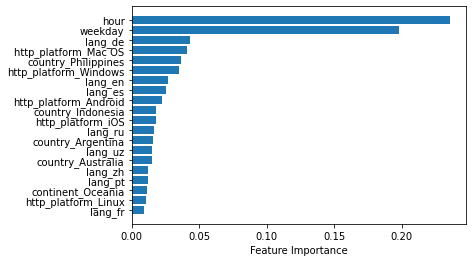

In [12]:
# There are probably many improvable aspects to the model (incl. parameter tweaking)
# But for now we will try to explain the model and see if we can extract the most important features
# For that, we will consider the outliers detected by the model as if they were positive cases in a classification model
# (they are not really, but for explainability purposes it should work)
# Then we fit a classifier over that and sort the features by importance

from sklearn.ensemble import ExtraTreesClassifier
from matplotlib import pyplot as plt

n_row = np.size(X, axis=0)
#print(N)
print(X.shape)

# Create a vector z that contains '1' if outlier (at least 3 times) and '0' if not
def set_as_num_occurs(z, cnt):
    tmp = cnt.most_common()
    for x in range(len(tmp)):
        if tmp[x][1] >= 3:
            #z[tmp[x][0]] = tmp[x][1]
            z[tmp[x][0]] = 1

z = np.zeros((n_row,1))
set_as_num_occurs(z, cnt)

# Need to get the names of the features; remember that we deleted the first two columns in X
features_names = data.columns[2:]
print(len(features_names))
#print(features_names[-150:-100])
Y = z.ravel()
model = ExtraTreesClassifier()
model.fit(X, Y)
#print(model.feature_importances_)
sort = model.feature_importances_.argsort()
sort_trunc = sort[-20:]
plt.barh(features_names[sort_trunc], model.feature_importances_[sort_trunc])
plt.xlabel("Feature Importance")

print("\nDone")

In [13]:
# 'hour' and 'weekday' are the most important features (in my results)
# Hard to decipher quickly from just looking at the raw results for k >= 3
# Would need to plot distribution of 'hour' and 'weekday' for outliers versus all

# Select outliers rows and subset from 'data'
def get_outliers_rows(cnt):
    tmp = cnt.most_common()
    rows = []
    for x in range(len(tmp)):
        if tmp[x][1] >= 3:
            rows.append(tmp[x][0])
    return rows

outliers_rows = get_outliers_rows(cnt)
outliers_data = data.iloc[outliers_rows, :]
print(outliers_data.shape)

print("\nDone")

(535, 293)

Done



Done


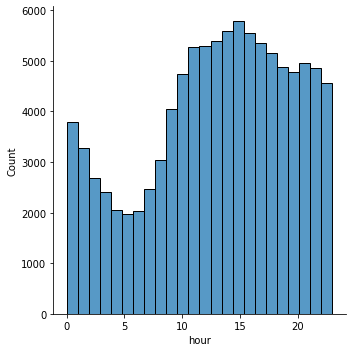

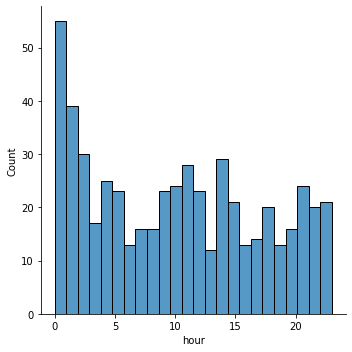

In [14]:
# Now we can plot the activity hour by hour, for the whole data vs. outliers

sns.displot(data['hour'], bins = 24)
sns.displot(outliers_data['hour'], bins = 24)

print("\nDone")

# Outliers definitely do not follow the same distribution
# with a lot of activity (allegedly) taking place in the early morning and the rest haphazardly throughout the day


Done


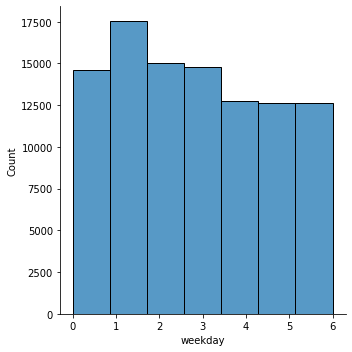

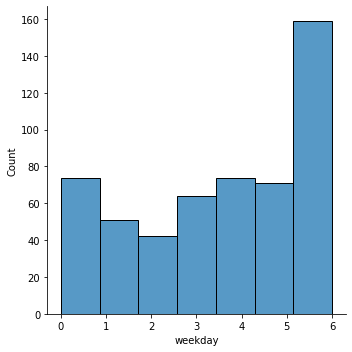

In [15]:
# Same thing for the days of the week ; all data vs. outliers

sns.displot(data['weekday'], bins = 7)
sns.displot(outliers_data['weekday'], bins = 7)

print("\nDone")

# For the outliers, there is a large spike of activity on Saturdays
# I do not know whether it is normal or not, but it explains the large importance given to these two features

In [ ]:
######################################################################################
# For the rest of the features, I relied on skimming through the ~500 outliers by hand
# to try and provide an outline of the major trends
######################################################################################

# The 'platforms' appear a lot in the top 20 features, but I don't know what it means

# 'lang_de' is interesting
# It seems to be used by users from several countries in Europe (Germany, Austri, Switzerland...which is normal)
# But also by very suspicious entries (e.g. Moscow timezones with Indonesian IP)

# IPs from Philippines and Indonesia are used in many suspicious entries

# Australia (and Oceania) have a mix of legit-looking entries
# and stranger ones with timezones in South America and Spanish languages, or the Russian timezones and such

# Most Venezuela IP entries look legit, but they are sometimes hijacked by Russian activity
# Since there are not many of them overall, all are lumped into outliers by the model

# Most Argentina IP entries look legit, but many don't have an associated 'js_timezone'
# Which triggers model suspicion apparently ; would need to delve more into these

# This explains that the 'lang_es' is an important feature, since it is use in South America
# But it also appears in strange entries with Australian or European IPs

# 'lang_ru' and 'lang_uz' are very common in suspicious entries
# 'lang_zh' and 'lang_pt' as well, with a noticeable group of entries from North America IPs, no timezone and these languages

# A decent proportion of entries with IPs from Nigeria also seem suspicious
# Like Venezuela, due to the small number of overall events from this place
# it is "hijacked" by strange activity

# 'lang_en' is not a determining factor in itself
# Although it appears a lot in entries with an IP from the Philippines (legit or not)
# And other places where the model finds outliers (Australia, North America, Nigeria...)